## I. Load data

In [1]:
# Máy local thì cần block này để load hình trong jupyter
import sys
from PIL import Image
sys.modules['Image'] = Image

In [26]:
train_path = 'D:/CBD robotics course/data/fruits/fruits-360/Training'
test_path = 'D:/CBD robotics course/data/fruits/fruits-360/Test'

In [27]:
from keras.preprocessing.image import ImageDataGenerator
# create a data generator
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
# load and iterate train dataset
train_it = data_gen.flow_from_directory(directory=train_path, target_size=(100,100), color_mode='rgb', class_mode='categorical',
                                       batch_size=64, subset='training')
val_it = data_gen.flow_from_directory(directory=train_path, target_size=(100,100), color_mode='rgb', class_mode='categorical',
                                     batch_size=64, subset='validation')
test_it = data_gen.flow_from_directory(directory=test_path, target_size=(100,100), color_mode='rgb', class_mode='categorical',
                                      batch_size=64)

Found 45852 images belonging to 114 classes.
Found 11424 images belonging to 114 classes.
Found 19548 images belonging to 114 classes.


Sau khi load dữ liệu qua method flow_from_directory những điều cần lưu ý:

- Hình màu thì set: color_mode="rgb"
- Để class_mode='categorical' tức là nó đã one hot encode phần label (y)
- Nếu để validation_split=0.2 trong ImageDataGenerator, thì từ train_path có thể tách ra tập train và tập validation, bằng cách set thông số subset='training' hay subset='validation'
- Phương thức này load dữ liệu qua batch_size. Ở đây là batch_size=64 tức là ở mỗi mini batches có 64 hình.

Những nhãn trên tập train là:

In [4]:
train_label = list(train_it.class_indices.keys())
print(train_label)
print('Số nhãn trên tập train:', len(train_label))

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Dates', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine', 'Nectarine Flat', 'Nut Forest', 'Nut Pecan', 'Onion Red', 'On

In [23]:
test_label = list(test_it.class_indices.keys())
print(test_label)
print('Số nhãn trên tập test:', len(test_label))

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Dates', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine', 'Nectarine Flat', 'Nut Forest', 'Nut Pecan', 'Onion Red', 'On

In [6]:
# Số lượng thực thể trên tập train, val và test
print('Số thực thể trên tập train:', train_it.samples)
print('Số thực thể trên tập validation:', val_it.samples)
print('Số thực thể trên tập test:', test_it.samples)

Số thực thể trên tập train: 45852
Số thực thể trên tập validation: 11424
Số thực thể trên tập test: 19548


In [7]:
# Test thử có nhãn nào có trên tập train mà không có trên tập test không
lis = []
for label in train_label:
    if label not in test_label:
        lis.append(label)
print(lis)        

[]


Vậy là không có nhãn nào trên tập test mà tập train không có.

## II. Build model

### 2.1 Import libraries

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras import backend as K
from IPython.display import display
from PIL import Image

### 2.2 Set saving check points

In [4]:
# Save checkpoint bằng callback trong Keras
from keras.callbacks import *
filepath= 'D:/CBD robotics course/Assignment/Assignment 08/epochs_{epoch:03d}-val_acc_{val_acc:.3f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

- Check point được chấm qua 'val_acc' nếu 'val_acc' này được cải thiện sẽ tự động lưu lại sao lần epoch đó.
- Tạo checkpoints để callback thì cần thiết bởi rất có thể trong môi trường không ổn định thì sẽ bị crash khi train dẫn đến phải train lại từ đầu. Có checkpoint thì ta chỉ việc load lại điểm của epoch đã hoàn tất.

### 2.3 Baseline model

In [17]:
# create larger_model
def larger_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (3,3), input_shape=(100, 100, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(114, activation='softmax'))
    # compile model
    lrate= 0.01
    decay= lrate/25
    sgd = SGD(lr=lrate, momentum=0.9, decay = decay, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

model = larger_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
dropout_7 (Dropout)          (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 64)        36928     
__________

Lần train bị crash phải load lại checkpoint. Muốn load lại check point thì đi qua các bước sau:

- Mount driver
- Định lại cấu trúc của mô hình
- Load lại checkpoint qua model.load_weights
- Compile mô hình
- Fit lại mô hình

In [2]:
from keras.models import load_model
model = load_model('D:/CBD robotics course/Assignment/Assignment 08/trained_model.h5')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [8]:
model.load_weights('D:/CBD robotics course/Assignment/Assignment 08/epochs_006-val_acc_0.889.hdf5')

In [9]:
# fit model
batch_size = 64
model.fit_generator(generator=train_it, verbose=1, callbacks= callbacks_list, validation_data=val_it,
                   steps_per_epoch= train_it.samples//batch_size,
                   validation_steps= val_it.samples//batch_size,
                   epochs=10)

Epoch 1/10
716/716 [==============================] - 83s 115ms/step - loss: 0.0025 - acc: 0.9994 - val_loss: 0.7885 - val_acc: 0.8735

Epoch 00001: val_acc did not improve from 0.88592
Epoch 2/10
716/716 [==============================] - 83s 116ms/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.7400 - val_acc: 0.8753

Epoch 00002: val_acc did not improve from 0.88592
Epoch 3/10
716/716 [==============================] - 83s 116ms/step - loss: 0.0017 - acc: 0.9995 - val_loss: 0.7554 - val_acc: 0.8736

Epoch 00003: val_acc did not improve from 0.88592
Epoch 4/10
716/716 [==============================] - 83s 116ms/step - loss: 0.0013 - acc: 0.9997 - val_loss: 0.7461 - val_acc: 0.8754

Epoch 00004: val_acc did not improve from 0.88592
Epoch 5/10
716/716 [==============================] - 83s 116ms/step - loss: 0.0021 - acc: 0.9993 - val_loss: 0.7589 - val_acc: 0.8731

Epoch 00005: val_acc did not improve from 0.88592
Epoch 6/10
716/716 [==============================] - 83s 116ms/step -

In [11]:
model.save('D:/CBD robotics course/Assignment/Assignment 08/trained_model.h5')

## III. Evaluation

### 3.1 Đánh giá trên đo lường accuracy

Model với 10 epochs

In [21]:
# evaluate model
loss = model.evaluate_generator(generator=test_it, steps=test_it.samples//batch_size)
print('Accuracy: %.2f' % (loss[1]*100))

Accuracy: 89.93


Model transfer learning với 30 epochs ( trong đó 10 epochs cuối cùng không cải thiện được độ chính xác của mô hình)

In [10]:
# evaluate model
loss = model.evaluate_generator(generator=test_it, steps=test_it.samples//batch_size)
print('Accuracy: %.2f' % (loss[1]*100))

Accuracy: 91.51


### 3.2 Đánh giá trên Classification Report

In [3]:
from keras.models import load_model
model = load_model('D:/CBD robotics course/Assignment/Assignment 08/trained_model.h5')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [4]:
from keras.preprocessing.image import ImageDataGenerator
# create a data generator
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_it = data_gen.flow_from_directory(directory=test_path, target_size=(100,100), color_mode='rgb', class_mode='categorical',
                                       batch_size= 1000)


Found 19548 images belonging to 114 classes.


In [5]:
# Đánh giá trên 1000 hình (tức là 1 batch)
X_test, y_test = next(test_it)

In [6]:
X_test.shape

(1000, 100, 100, 3)

In [7]:
y_test.shape

(1000, 114)

In [8]:
predicted_y = model.predict(X_test, batch_size=1000) # Predict hết X_test, vì X_test có 2000 hình

In [9]:
predicted_y.shape

(1000, 114)

Chuyển các vector (là array các label từng hình đã được one hot encode) trong y_test, predicted_y về argmax (tức là chỉ chọn về đúng kết quả)<br>
Lưu ý argmax trả về index nên cả 2 array y_test, predicted_y phải cùng làm bước này.

In [11]:
import numpy as np
y_pred = np.argmax(predicted_y, axis=1)
y_true = np.argmax(y_test, axis=1)

**Lập báo cáo**

In [12]:
from sklearn.metrics import classification_report
result = classification_report(y_true=y_true, y_pred=y_pred)
print(result)

              precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       1.00      0.80      0.89         5
           2       0.33      0.22      0.27         9
           3       0.50      0.67      0.57         9
           4       0.83      1.00      0.91         5
           5       1.00      0.92      0.96        12
           6       0.73      1.00      0.84         8
           7       1.00      0.75      0.86         4
           8       0.78      1.00      0.88         7
           9       0.89      1.00      0.94         8
          10       1.00      1.00      1.00        11
          11       1.00      0.50      0.67        10
          12       1.00      0.92      0.96        13
          13       1.00      1.00      1.00         5
          14       0.73      1.00      0.84         8
          15       1.00      1.00      1.00         8
          16       0.33      0.50      0.40         4
          17       0.91    

Tìm những label mà mô hình phân loại kém chính xác ( precision hoặc recall nhỏ hơn hoặc bằng 0.5)

In [15]:
# biến classification report về dictionary
result = classification_report(y_true=y_true, y_pred=y_pred, output_dict=True)
type(result)

dict

In [16]:
# Bỏ những key không phải label
del result['accuracy']
del result['macro avg']
del result['weighted avg']

In [18]:
result # cấu trúc của cái dic này

{'0': {'precision': 1.0,
  'recall': 0.375,
  'f1-score': 0.5454545454545454,
  'support': 8},
 '1': {'precision': 1.0,
  'recall': 0.8,
  'f1-score': 0.888888888888889,
  'support': 5},
 '2': {'precision': 0.3333333333333333,
  'recall': 0.2222222222222222,
  'f1-score': 0.26666666666666666,
  'support': 9},
 '3': {'precision': 0.5,
  'recall': 0.6666666666666666,
  'f1-score': 0.5714285714285715,
  'support': 9},
 '4': {'precision': 0.8333333333333334,
  'recall': 1.0,
  'f1-score': 0.9090909090909091,
  'support': 5},
 '5': {'precision': 1.0,
  'recall': 0.9166666666666666,
  'f1-score': 0.9565217391304348,
  'support': 12},
 '6': {'precision': 0.7272727272727273,
  'recall': 1.0,
  'f1-score': 0.8421052631578948,
  'support': 8},
 '7': {'precision': 1.0,
  'recall': 0.75,
  'f1-score': 0.8571428571428571,
  'support': 4},
 '8': {'precision': 0.7777777777777778,
  'recall': 1.0,
  'f1-score': 0.8750000000000001,
  'support': 7},
 '9': {'precision': 0.8888888888888888,
  'recall': 1.

In [19]:
# test thử
result['0']['recall']

0.375

In [20]:
lack_of_precision = [] # các nhãn kém về precision
lack_of_recall = [] # các nhãn kém về recall

for k in result.keys():
    if result[k]['precision'] <= 0.5:
        lack_of_precision.append(k)
    if result[k]['recall'] <= 0.5:
        lack_of_recall.append(k)
print('Những nhãn có precision thấp:', lack_of_precision)
print('Những nhãn có recall thấp:', lack_of_recall)

Những nhãn có precision thấp: ['2', '3', '16', '62']
Những nhãn có recall thấp: ['0', '2', '11', '16', '62', '79']


In [22]:
# decode các nhãn này thành plain text
def decode_label(target):
    '''Decode các nhãn'''
    lis = [] #initial list
    for k,v in test_it.class_indices.items():
        if str(v) in target:
            lis.append(k)
    return lis
print('Những nhãn có precision thấp:', decode_label(lack_of_precision))
print('Những nhãn có recall thấp:', decode_label(lack_of_recall))

Những nhãn có precision thấp: ['Apple Golden 1', 'Apple Golden 2', 'Banana', 'Nectarine']
Những nhãn có recall thấp: ['Apple Braeburn', 'Apple Golden 1', 'Apple Red Yellow 1', 'Banana', 'Nectarine', 'Pear Red']


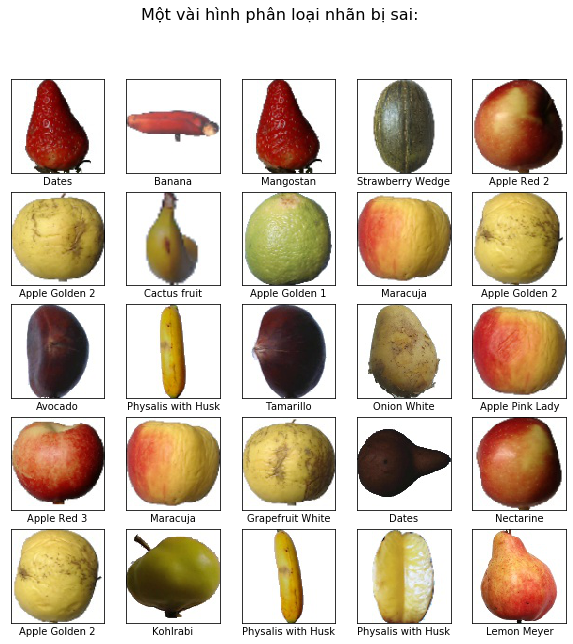

In [26]:
import matplotlib.pyplot as plt
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Một vài hình phân loại nhãn bị sai:", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(mislabeled_images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[mislabeled_labels[i]])
    plt.show()
    
#predictions = model.predict(test_images)
#pred_labels = np.argmax(predictions, axis = 1)
print_mislabeled_images(test_label, X_test, y_true, y_pred)    

**Thử với một hình download từ bên ngoài**

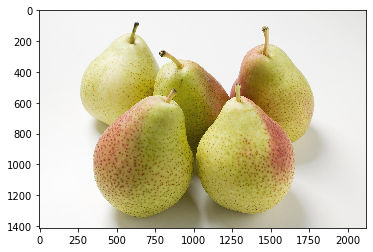

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
# Load an color image in color
img = cv2.imread('Forelle-Pears.jpg',1) # 1 là load hình màu
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # để hiện màu trên jupyter notebook
#Show the image with matplotlib
plt.imshow(img)
plt.show()

In [6]:
type(img)

numpy.ndarray

In [7]:
img.shape

(1412, 2123, 3)

In [25]:
# resize và reshape lại để chạy được trên mô hình
new_img = cv2.resize(img, (100,100)) #resize
new_img= new_img.reshape(1, 100 , 100, 3)
new_img.shape

(1, 100, 100, 3)

In [24]:
predicted = model.predict(new_img)
predicted = np.argmax(predicted)
print(predicted)

86


In [29]:
mydict = test_it.class_indices
print(list(mydict.keys())[list(mydict.values()).index(predicted)])

Physalis with Husk


_Dữ liệu trên tập train_ là **single image** và rất **clean** (không có background). Nên dù nhãn 86 có tỷ lệ precision và recall cao nhưng dự đoán vẫn **trật** trên một **multiple image**. Kết quả đáng ra phải ra nhãn có chữ Pear.

## IV. Conclusions
- Nếu là máy local thì phải thêm các bước ở đầu (cell 1) để có thể chạy được trên jupyter notebook
- Chú ý đường dẫn, path của window mặc định là dấu \ nhưng các libraries hiểu theo dấu /, không đặt các tên file lưu (checkpoint) có kí tự đặc biệt như ':'
- Tăng số lượng epoch đến một mức nào đó thì mô hình cũng không thể cải thiện được điểm số nữa.
- Phần classification chỉ dùng batch 1000 hình là bởi nếu dùng nhiều hơn thì bộ nhớ VRAM của GPU không tải được nữa. Có lẽ sẽ còn cách nào đó khác để làm phần này với nhiều hình hơn.
- Transfer learning như ở phần này là train mô hình với 10 epoch xong load lại model hay load lại weight, tiếp tục fit để train tiếp.
- Chỗ evaluate_generator, thì steps=test_it.samples//batch_size nghĩa là đánh giá hết cả tập test. Hiểu steps ở đây là số batch, với batch_size ngay đầu tiên là 64 thì số hình được đánh giá ở đây là **steps x 64 = số hình đánh giá**. Nên để đánh giá hết dữ liệu test, ta lấy tất cả các samples là test_it.samples chia cho batch_size (64) = số batch (tức steps)